In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['iwildcam-2019-fgvc6', 'reshape32x32']


In [2]:
# KERNEL FOR IMPOVE TRAIN AND DEV SETS: REMOVE THE MOST OF ZEROS

In [3]:
train= pd.read_csv("../input/iwildcam-2019-fgvc6/train.csv")
test= pd.read_csv("../input/iwildcam-2019-fgvc6/test.csv")
sample_submission= pd.read_csv("../input/iwildcam-2019-fgvc6/sample_submission.csv")
print("train.shape:", train.shape)
print("test.shape:", test.shape)
print("sample_submmission.shape:", sample_submission.shape)

train_images = '../input/train_images/*'
test_images = '../input/test_images/*'

train.shape: (196299, 11)
test.shape: (153730, 10)
sample_submmission.shape: (153730, 2)


In [4]:
import cv2
import glob
import matplotlib.pyplot as plt
import tqdm
import tensorflow as tf
from tensorflow.python.framework import ops
import scipy
from scipy import ndimage
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from PIL import Image

In [5]:
train.head()

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747
2,0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747
3,0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747
4,0,2011-07-12 13:11:16,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,3,599fbd89-23d2-11e8-a6a3-ec086b02610b,46,Justin Brown,6f1728a1-5567-11e8-9be7-dca9047ef277,3,1024,747


0     131457
19     14106
13      8623
11      7209
8       6938
1       6102
16      5975
17      4759
3       3398
18      3035
4       2210
14      1361
10      1093
22        33
Name: category_id, dtype: int64

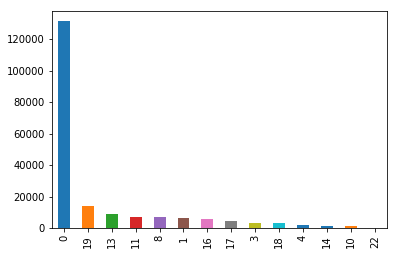

In [6]:
train['category_id'].value_counts()[0:16].plot(kind='bar')
train.category_id.value_counts()

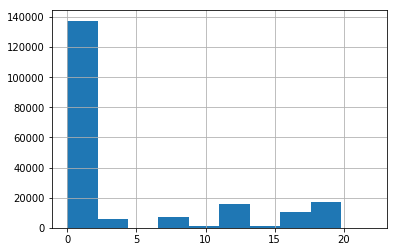

In [7]:
train.category_id.hist()

In [8]:
# Get ids and labels
train_id = train['file_name']
labels = train['category_id']
test_id = sample_submission['Id']


In [9]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [10]:
# Generation of y_train with one_hot:
etiquetas=train['category_id']
y_trains = []
for i in range(train.shape[0]):
    y_train = convert_to_one_hot(etiquetas[i],23)
    y_trains.append(y_train)
    
y_train=np.stack(y_trains)
y_train=np.reshape(y_train, (y_train.shape[0],y_train.shape[1]))
np.save('../working/y_train.npy', y_train)

print(y_train.shape)

(196299, 23)


In [11]:
# The data, load data:
x_train_arr = np.load('../input/reshape32x32/X_train.npy')
x_test_arr = np.load('../input/reshape32x32/X_test.npy')
y_train_arr = np.load('../working/y_train.npy')

print('x_train_arr shape:', x_train_arr.shape)
print('x_test_arr shape:', x_test_arr.shape)
print('y_train_arr shape:', y_train_arr.shape)

print(x_train_arr.shape[0], 'train samples')
print(x_test_arr.shape[0], 'test samples')

x_train_arr shape: (196299, 32, 32, 3)
x_test_arr shape: (153730, 32, 32, 3)
y_train_arr shape: (196299, 23)
196299 train samples
153730 test samples


In [12]:
# Convert the images to float and scale it to a range of 0 to 1
x_train = x_train_arr.astype('float32')
y_train = y_train_arr.astype('float32')
x_test = x_test_arr.astype('float32')

x_train /= 255.
x_test /= 255.

print("x_train.shape:",x_train.shape)
print("y_train.shape:",y_train.shape)
print("x_test.shape:",x_test.shape)
print()
print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])

x_train.shape: (196299, 32, 32, 3)
y_train.shape: (196299, 23)
x_test.shape: (153730, 32, 32, 3)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
samples_zero = 195500 # 1000 #Numero de elementos a escanear para QUITAR etiquetas con label=0

x_train_prueba = x_train 
y_train_prueba = y_train 
delet=[]

for i in range (samples_zero):
    test=y_train_prueba[i,0]
    if test==1.0:
        delet.append(i)          
x_trains1 = np.delete(x_train_prueba, delet,axis=0)
y_trains1 = np.delete(y_train_prueba, delet,axis=0)

# RETURN the new values for Train and Dev datasets)
print( "New values for TRAIN and DEV datasets: ")
print( "-------------------------------------- ")
print("TOTAL (X_train + X_dev shapes): ", x_trains1.shape)
print("TOTAL (Y_train + Y_dev shapes): ", y_trains1.shape)     

New values for TRAIN and DEV datasets: 
-------------------------------------- 
TOTAL (X_train + X_dev shapes):  (65404, 32, 32, 3)
TOTAL (Y_train + Y_dev shapes):  (65404, 23)


In [14]:
np.save('../working/x_trains1.npy', x_trains1)
np.save('../working/y_trains1.npy', y_trains1)

In [15]:
print(os.listdir("../working"))

['__output__.json', '__notebook__.ipynb', 'y_trains1.npy', 'y_train.npy', 'x_trains1.npy']
